In [25]:
import glob
import geopandas as gpd
import os
from shutil import copy
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import cv2
from patchify import patchify, unpatchify
from osgeo import gdal, ogr, osr
import imgaug as ia
import imgaug.augmenters as iaa
from imgaug.augmentables.segmaps import SegmentationMapsOnImage


In [28]:
def make_dirs(dir_path):
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)
    return dir_path

def vecToRaster(refRaster, shapeFile, attribute, outPut, burnInval=None,):
    shp_driver = ogr.GetDriverByName('ESRI Shapefile')

    ras_ds = gdal.Open(refRaster) 
    vec_ds = shp_driver.Open(shapeFile) 
    lyr = vec_ds.GetLayer() 
    geot = ras_ds.GetGeoTransform()

    drv_tiff = gdal.GetDriverByName("GTiff") 
    chn_ras_ds = drv_tiff.Create(f'{outPut}', ras_ds.RasterXSize, ras_ds.RasterYSize, 1, gdal.GDT_Int16)
    chn_ras_ds.SetGeoTransform(geot)
                           
    gdal.RasterizeLayer(chn_ras_ds, [burnInval], lyr, options=[f'ATTRIBUTE={attribute}'])
    chn_ras_ds.GetRasterBand(1).SetNoDataValue(0.0) 
    chn_ras_ds = None

def clipIMG(image, patch_size, outout_dir, data_type=None):
    name = os.path.basename(image)[:-4]
    
    img = rasterio.open(image).read(1)
    x_dim = (img.shape[0]//patch_size)*patch_size
    y_dim = (img.shape[1]//patch_size)*patch_size
    input_img = rasterio.open(image).read()
    if input_img.shape[0] > 1:
        print('3D', input_img.shape[0])
        new_img = input_img[:,:x_dim, :y_dim]
        # print(input_img.shape)
        patches = patchify(new_img, patch_size=(input_img.shape[0], patch_size, patch_size), step=patch_size)
        # print(patches.shape)
        for i in np.arange(patches.shape[1]):
            for s in np.arange(patches.shape[2]):
                single_patch = np.transpose(patches[0,i,s,:,:,:], (1,2,0))
                # single_patch = patches[0,i,s,:,:,:]
                # print(single_patch.shape)
                cv2.imwrite(f'patches/{name}_{data_type}_{i}{s}.png', single_patch)
                
    else:
        print('2D', input_img.shape[0])
        new_img = input_img[0,:x_dim, :y_dim]
        patches = patchify(new_img, patch_size=(patch_size, patch_size), step=patch_size)
        # print(patches.shape)
        for i in np.arange(patches.shape[0]):
            for s in np.arange(patches.shape[1]):
                single_patch = patches[i,s,:,:]
                # print(single_patch.shape)
                if data_type == 'image':
                    cv2.imwrite(f'{outout_dir}/{name}_{data_type}_{i}{s}.png', single_patch)
                if data_type == 'mask':
                    cv2.imwrite(f'{outout_dir}/{name}_{data_type}_{i}{s}.png', single_patch)


aug_t1 = iaa.Sequential([
    iaa.Fliplr(0.5), # horizontally flip 50% of the images
])
aug_t2 = iaa.Sequential([
    iaa.Flipud(0.5), # horizontally flip 50% of the images
])

def augment_seg(aug, img , msk):
	aug_det = aug.to_deterministic() 
	image_aug = aug_det.augment_image(img)

	mskmap = SegmentationMapsOnImage(msk, shape=img.shape)
	mskmap_aug = aug_det.augment_segmentation_maps(mskmap)
	mskmap_aug = mskmap_aug.get_arr()

	return image_aug , mskmap_aug

In [9]:
imgs = glob.glob('./use_images/NS*.tif')
shps = glob.glob('./SegImage/merged_mask_shape/NS*.shp')

In [10]:
shps

['./SegImage/merged_mask_shape/NS7791.shp',
 './SegImage/merged_mask_shape/NS8088.shp',
 './SegImage/merged_mask_shape/NS7692.shp',
 './SegImage/merged_mask_shape/NS7790.shp',
 './SegImage/merged_mask_shape/NS8195.shp',
 './SegImage/merged_mask_shape/NS8095.shp',
 './SegImage/merged_mask_shape/NS7691.shp',
 './SegImage/merged_mask_shape/NS7792.shp',
 './SegImage/merged_mask_shape/NS7891.shp',
 './SegImage/merged_mask_shape/NS8093.shp',
 './SegImage/merged_mask_shape/NS8092.shp',
 './SegImage/merged_mask_shape/NS8094.shp',
 './SegImage/merged_mask_shape/NS7993.shp']

In [11]:

for p in shps:
    s = [h for h in imgs if os.path.basename(h)[:-4]==os.path.basename(p)[:-4]][0]
    print(s)
    vecToRaster(refRaster=s, 
                shapeFile=p, 
                attribute='Class', 
                outPut=f'./SegImage/merged_mask_shape/{os.path.basename(p)[:-4]}.tif',
                burnInval=1)
    

./use_images/NS7791.tif
./use_images/NS8088.tif
./use_images/NS7692.tif
./use_images/NS7790.tif
./use_images/NS8195.tif
./use_images/NS8095.tif
./use_images/NS7691.tif
./use_images/NS7792.tif
./use_images/NS7891.tif
./use_images/NS8093.tif
./use_images/NS8092.tif
./use_images/NS8094.tif
./use_images/NS7993.tif


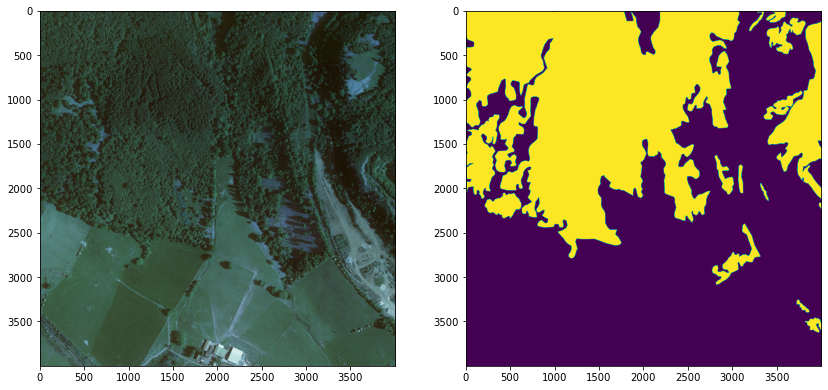

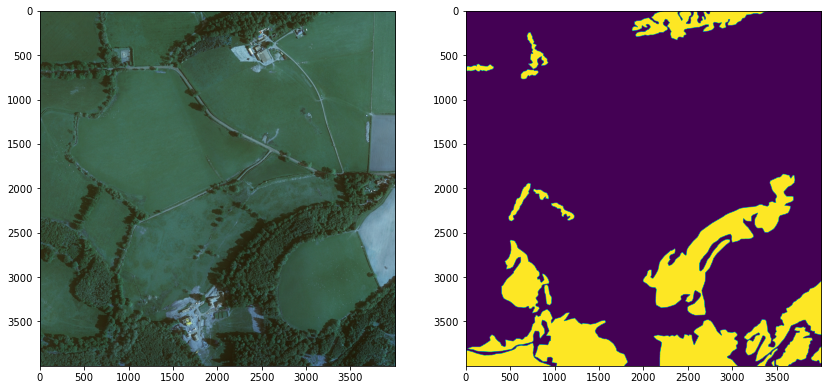

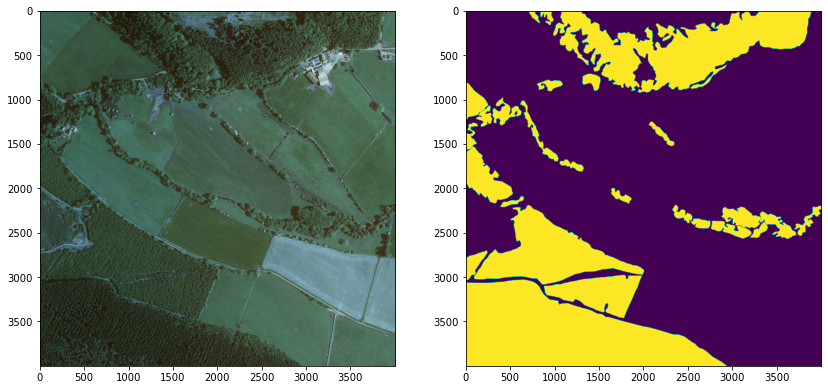

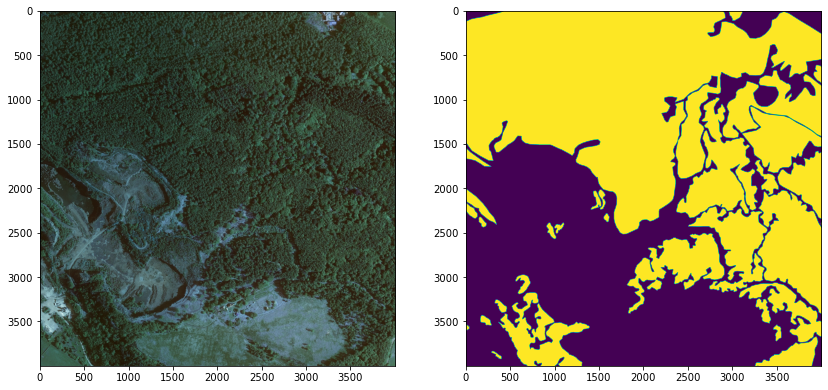

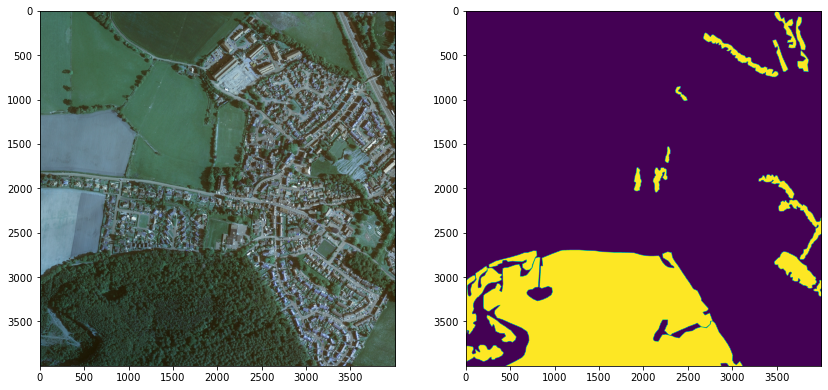

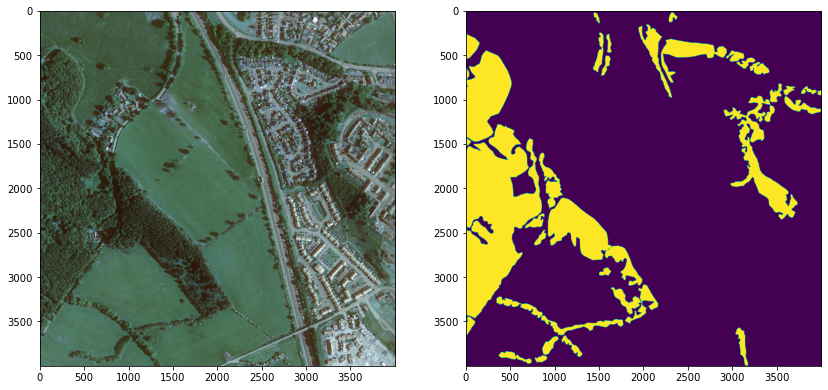

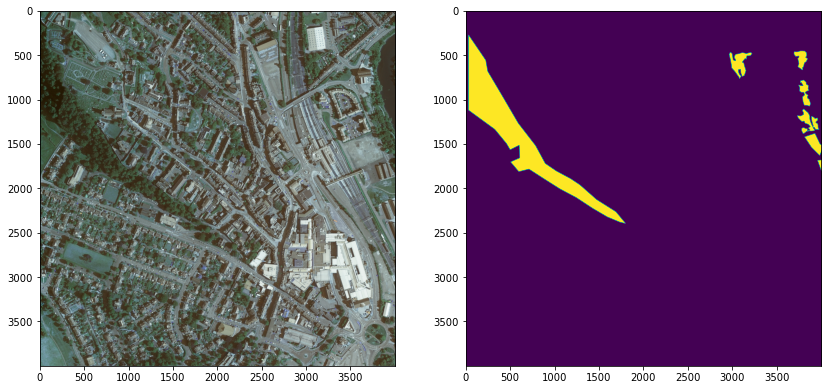

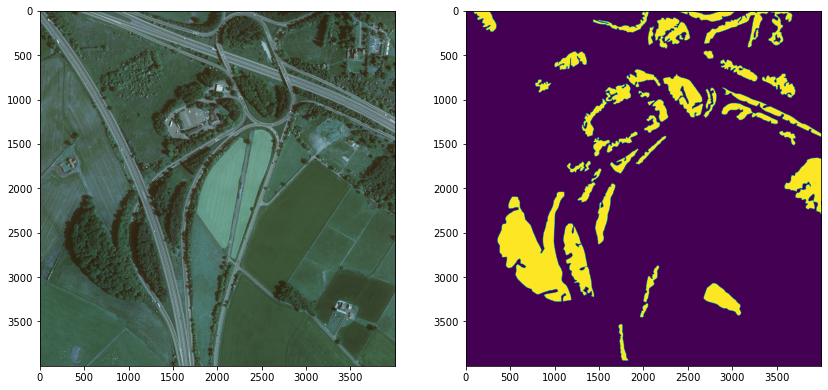

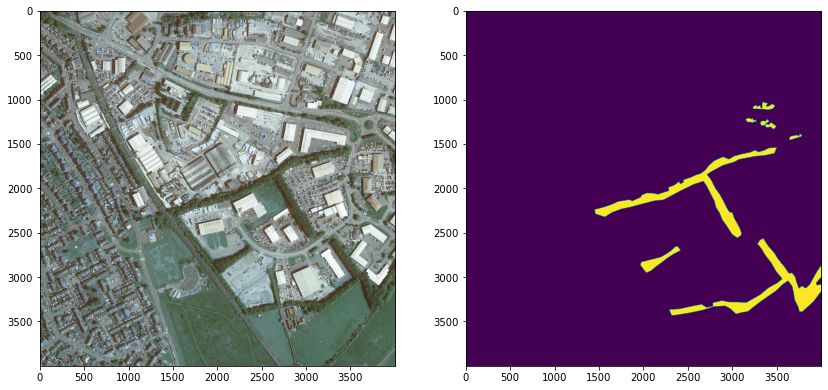

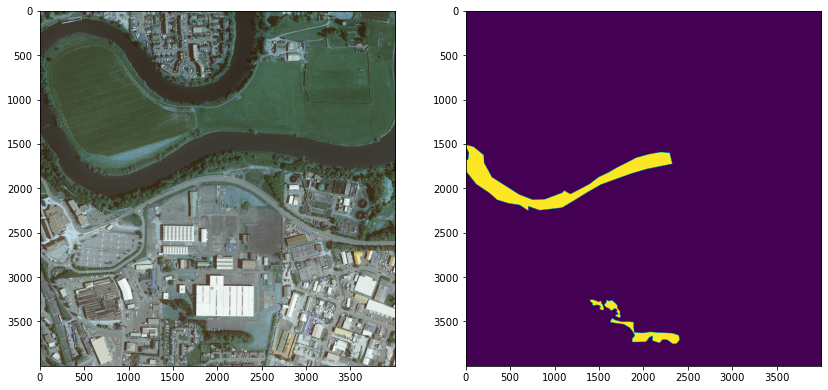

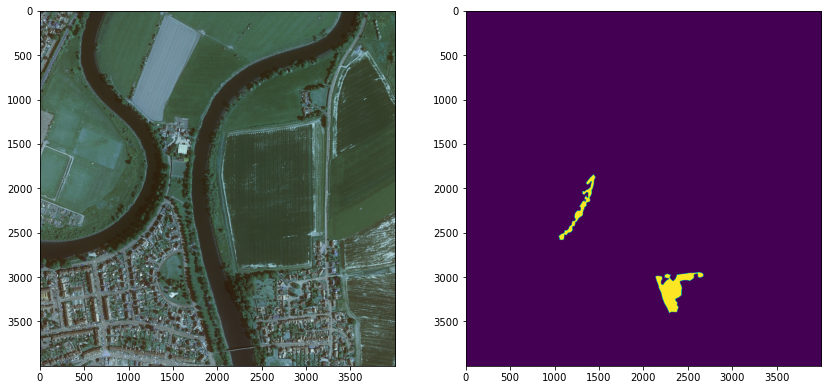

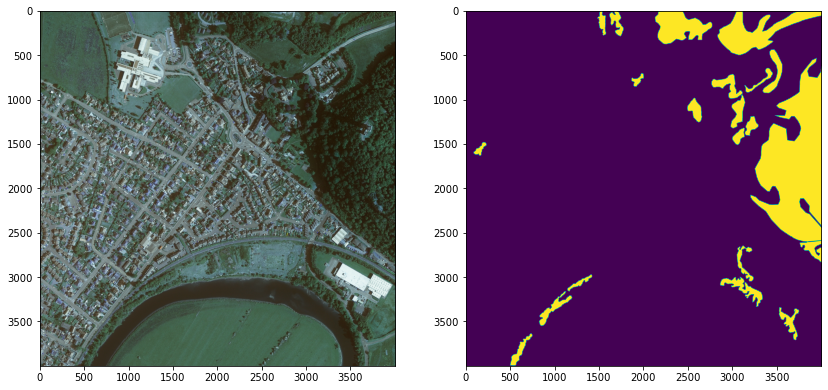

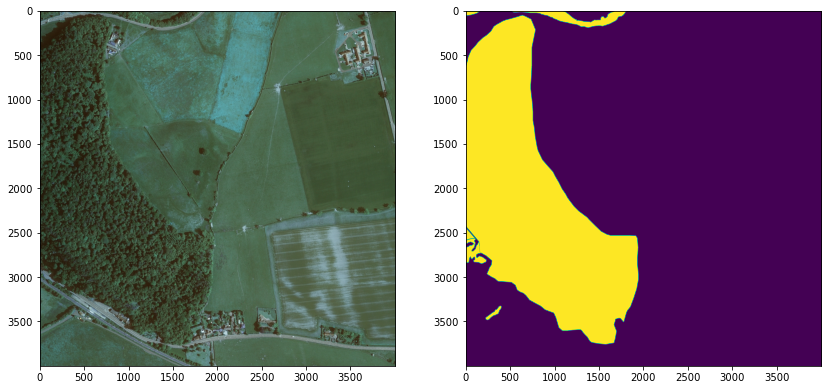

In [12]:
all_imgs = sorted(glob.glob('./SegImage/merged_mask_shape/NS*jpg'))
all_mask = sorted(glob.glob('./SegImage/merged_mask_shape/NS*tif'))
for img in all_imgs:
    msk = [h for h in all_mask if os.path.basename(h)[:-4]==os.path.basename(img)[:-4]][0]

    marr = cv2.imread(msk, -1)
    iarr = cv2.imread(img, -1)
    fig, axs = plt.subplots(nrows=1,ncols=2, figsize=(14, 7))
    axs[0].imshow(iarr);
    axs[1].imshow(marr);

In [14]:
all_imgs = sorted(glob.glob('./SegImage/merged_mask_shape/NS*jpg'))
all_mask = sorted(glob.glob('./SegImage/merged_mask_shape/NS*tif'))
all_imgs[:3], all_mask[:3]

(['./SegImage/merged_mask_shape/NS7691.jpg',
  './SegImage/merged_mask_shape/NS7692.jpg',
  './SegImage/merged_mask_shape/NS7790.jpg'],
 ['./SegImage/merged_mask_shape/NS7691.tif',
  './SegImage/merged_mask_shape/NS7692.tif',
  './SegImage/merged_mask_shape/NS7790.tif'])

In [15]:
for img in all_imgs:
    msk = [h for h in all_mask if os.path.basename(h)[:-4]==os.path.basename(img)[:-4]][0]
    print(img, '--->', msk)
    clipIMG(image=img, patch_size=256, outout_dir=make_dirs('patches'), data_type='image')
    clipIMG(image=msk, patch_size=256,outout_dir=make_dirs('patches'), data_type='mask')

./SegImage/merged_mask_shape/NS7691.jpg ---> ./SegImage/merged_mask_shape/NS7691.tif


/home/mortimer/anaconda3/envs/deep_env/lib/python3.10/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


3D 3
2D 1
./SegImage/merged_mask_shape/NS7692.jpg ---> ./SegImage/merged_mask_shape/NS7692.tif
3D 3
2D 1
./SegImage/merged_mask_shape/NS7790.jpg ---> ./SegImage/merged_mask_shape/NS7790.tif
3D 3
2D 1
./SegImage/merged_mask_shape/NS7791.jpg ---> ./SegImage/merged_mask_shape/NS7791.tif
3D 3
2D 1
./SegImage/merged_mask_shape/NS7792.jpg ---> ./SegImage/merged_mask_shape/NS7792.tif
3D 3
2D 1
./SegImage/merged_mask_shape/NS7891.jpg ---> ./SegImage/merged_mask_shape/NS7891.tif
3D 3
2D 1
./SegImage/merged_mask_shape/NS7993.jpg ---> ./SegImage/merged_mask_shape/NS7993.tif
3D 3
2D 1
./SegImage/merged_mask_shape/NS8088.jpg ---> ./SegImage/merged_mask_shape/NS8088.tif
3D 3
2D 1
./SegImage/merged_mask_shape/NS8092.jpg ---> ./SegImage/merged_mask_shape/NS8092.tif
3D 3
2D 1
./SegImage/merged_mask_shape/NS8093.jpg ---> ./SegImage/merged_mask_shape/NS8093.tif
3D 3
2D 1
./SegImage/merged_mask_shape/NS8094.jpg ---> ./SegImage/merged_mask_shape/NS8094.tif
3D 3
2D 1
./SegImage/merged_mask_shape/NS8095.jpg 

In [16]:
images = glob.glob('patches/*image*png')
masks = glob.glob('patches/*mask*png')
len(images), len(masks)

(2860, 2860)

In [17]:
imgs = glob.glob('patches/*image*png')
masks = glob.glob('patches/*mask*png')
for i in imgs:
    arr = cv2.imread(i, -1)
    name = os.path.basename(i)
    fname = name.split('_')[0]
    num = name.split('_')[-1][:-4]
    print(name, num)
    t = [m for m in masks if (fname == os.path.basename(m).split('_')[0]) & (num == os.path.basename(m).split('_')[-1][:-4])][0]
    print(t)
    arr2 = cv2.imread(t, -1)
    if (np.sum(arr2)>1.0):
        # print(i.split('/')[-1],t.split('/')[-1])
        copy(i, make_dirs('trueMask_images'))
        copy(t, make_dirs('trueMask_images'))

NS8195_image_91.png 91
patches/NS8195_mask_91.png
NS8092_image_78.png 78
patches/NS8092_mask_78.png
NS8093_image_613.png 613
patches/NS8093_mask_613.png
NS8095_image_1312.png 1312
patches/NS8095_mask_1312.png
NS7792_image_1012.png 1012
patches/NS7792_mask_1012.png
NS7791_image_410.png 410
patches/NS7791_mask_410.png
NS7891_image_88.png 88
patches/NS7891_mask_88.png
NS7692_image_010.png 010
patches/NS7692_mask_010.png
NS7790_image_115.png 115
patches/NS7790_mask_115.png
NS7791_image_810.png 810
patches/NS7791_mask_810.png
NS8093_image_82.png 82
patches/NS8093_mask_82.png
NS8095_image_130.png 130
patches/NS8095_mask_130.png
NS7790_image_613.png 613
patches/NS7790_mask_613.png
NS7791_image_1110.png 1110
patches/NS7791_mask_1110.png
NS7891_image_35.png 35
patches/NS7891_mask_35.png
NS7692_image_108.png 108
patches/NS7692_mask_108.png
NS8094_image_01.png 01
patches/NS8094_mask_01.png
NS8094_image_90.png 90
patches/NS8094_mask_90.png
NS7792_image_51.png 51
patches/NS7792_mask_51.png
NS8195_i

In [34]:
imgs1 = sorted(glob.glob('trueMask_images/*image*png')) 
mask0 = sorted(glob.glob('trueMask_images/*mask*png'))
len(mask0)

2092

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


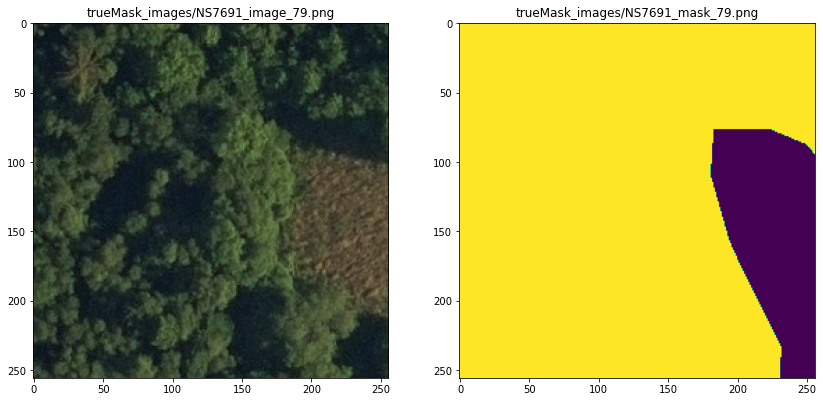

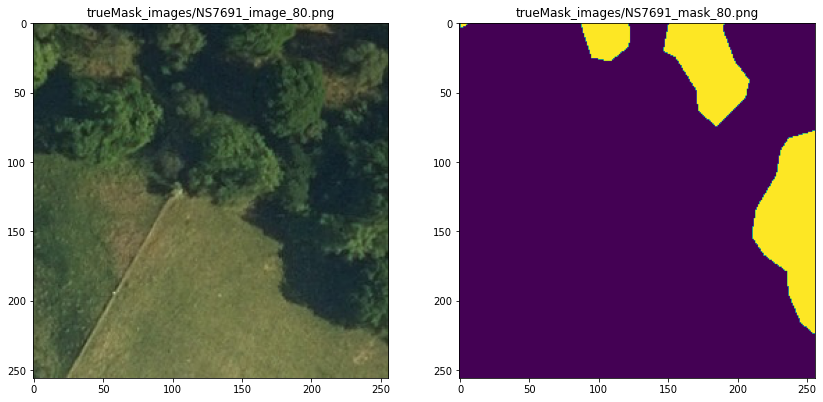

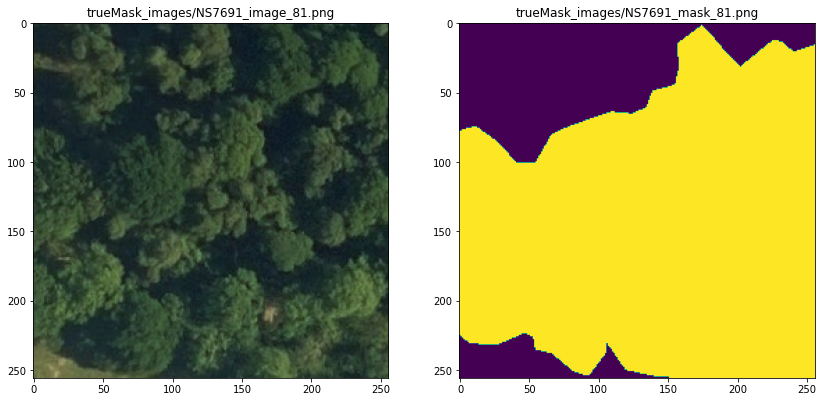

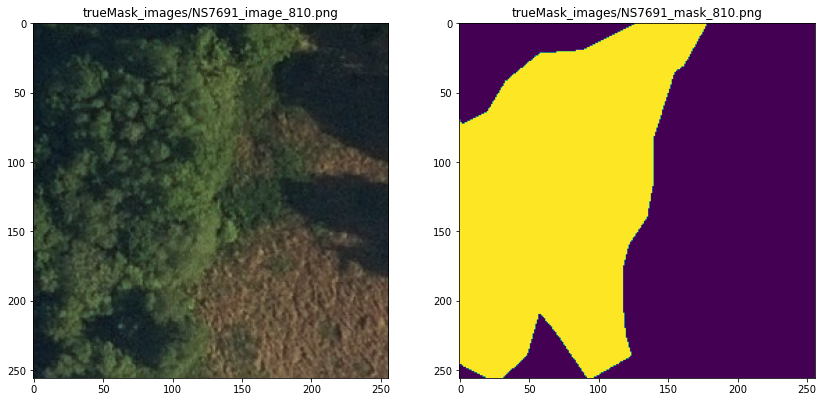

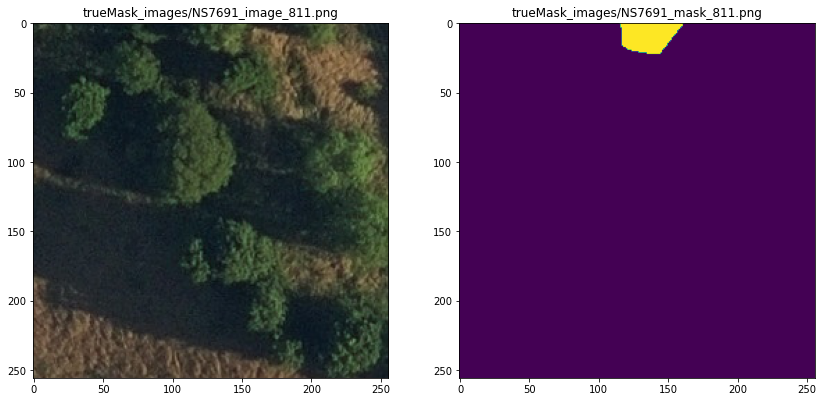

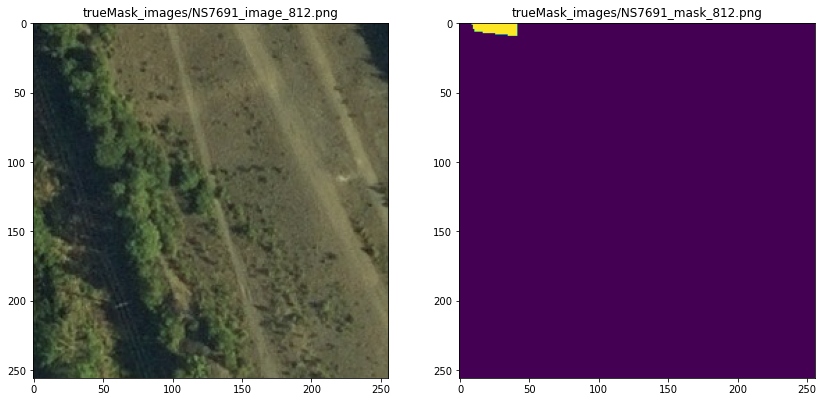

In [30]:
for i in mask0[120:126]:
    arr_m = cv2.imread(i, -1)
    name = i.split('/')[-1].split('_')[-1]
    num = i.split('/')[-1].split('_')[0]
    t = [m for m in imgs1 if (name == m.split('/')[-1].split('_')[-1]) & (num == m.split('/')[-1].split('_')[0])][0]
    arr_i = cv2.imread(t, -1)
    print(arr_i.shape)
    fig, axs = plt.subplots(nrows=1,ncols=2, figsize=(14, 7))
    axs[0].set_title(t);
    axs[0].imshow(arr_i);
    axs[1].set_title(i);
    axs[1].imshow(arr_m);


In [33]:
for i in mask0[100:]:
    arr_m = cv2.imread(i, -1)
    name = i.split('/')[-1].split('_')[-1]
    num = i.split('/')[-1].split('_')[0]
    t = [m for m in imgs1 if (name == m.split('/')[-1].split('_')[-1]) & (num == m.split('/')[-1].split('_')[0])][0]
    arr_i = cv2.imread(t, -1)
    mname = os.path.basename(i)[:-4]
    iname = os.path.basename(t)[:-4]
    aug_arr = augment_seg(aug_t2, arr_i, arr_m)
    print(aug_arr[0].shape, aug_arr[1].shape)
    cv2.imwrite(f'trueMask_images/{iname}a.png', aug_arr[0])
    cv2.imwrite(f'trueMask_images/{mname}a.png', aug_arr[1])
    # fig, axs = plt.subplots(nrows=1,ncols=2, figsize=(14, 7))
    # axs[0].set_title(t);
    # axs[0].imshow(aug_arr[0]);
    # axs[1].set_title(i);
    # axs[1].imshow(aug_arr[1]);

(256, 256, 3) (256, 256)
(256, 256, 3) (256, 256)
(256, 256, 3) (256, 256)
(256, 256, 3) (256, 256)
(256, 256, 3) (256, 256)
(256, 256, 3) (256, 256)
(256, 256, 3) (256, 256)
(256, 256, 3) (256, 256)
(256, 256, 3) (256, 256)
(256, 256, 3) (256, 256)
(256, 256, 3) (256, 256)
(256, 256, 3) (256, 256)
(256, 256, 3) (256, 256)
(256, 256, 3) (256, 256)
(256, 256, 3) (256, 256)
(256, 256, 3) (256, 256)
(256, 256, 3) (256, 256)
(256, 256, 3) (256, 256)
(256, 256, 3) (256, 256)
(256, 256, 3) (256, 256)
(256, 256, 3) (256, 256)
(256, 256, 3) (256, 256)
(256, 256, 3) (256, 256)
(256, 256, 3) (256, 256)
(256, 256, 3) (256, 256)
(256, 256, 3) (256, 256)
(256, 256, 3) (256, 256)
(256, 256, 3) (256, 256)
(256, 256, 3) (256, 256)
(256, 256, 3) (256, 256)
(256, 256, 3) (256, 256)
(256, 256, 3) (256, 256)
(256, 256, 3) (256, 256)
(256, 256, 3) (256, 256)
(256, 256, 3) (256, 256)
(256, 256, 3) (256, 256)
(256, 256, 3) (256, 256)
(256, 256, 3) (256, 256)
(256, 256, 3) (256, 256)
(256, 256, 3) (256, 256)
